In [1]:
import torch
from torch import nn
import matplotlib.pyplot as plt

from ccn import Constraint, ConstraintsGroup
from shapes import Rectangle
from experiment import Experiment

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


### Define the shapes

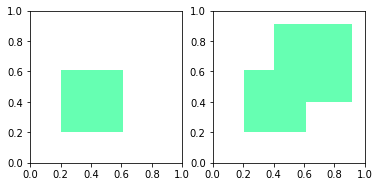

In [2]:
rect0 = Rectangle(0.2, 0.6, 0.2, 0.6)
rect1 = Rectangle(0.4, 0.9, 0.4, 0.9)
combined = rect0 | rect1
shapes = [rect0, combined]

fig, ax = plt.subplots(1, len(shapes))
for i, shape in enumerate(shapes):
  shape.plot(ax[i], full=True)
plt.show()

constraints1 = [ConstraintsGroup([Constraint('1 :- 0')])]
constraints2 = [ConstraintsGroup([Constraint('n0 :- n1')])]

### Define the neural network

In [3]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.linear = nn.Sequential(
            nn.Linear(2, 4),
            nn.Tanh(),
            nn.Linear(4, 2),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.linear(x)
        return x

model1 = NeuralNetwork()
model2 = NeuralNetwork()
print(model1)

NeuralNetwork(
  (linear): Sequential(
    (0): Linear(in_features=2, out_features=4, bias=True)
    (1): Tanh()
    (2): Linear(in_features=4, out_features=2, bias=True)
    (3): Sigmoid()
  )
)


### Train and test the model

In [4]:
experiment = Experiment('rectangles', model1, shapes, constraints1)
experiment.run(500)
experiment.save(dir='./models/')

Epoch 1
-------------------------------
loss: 0.761702 [    0/10000]
loss: 0.584226 [ 6400/10000]
Test Error: 
 Accuracy: 82.9%, 60.2%
 Avg loss: 0.008812 

Epoch 2
-------------------------------
loss: 0.526031 [    0/10000]
loss: 0.583265 [ 6400/10000]
Test Error: 
 Accuracy: 82.9%, 56.9%
 Avg loss: 0.008723 

Epoch 3
-------------------------------
loss: 0.522077 [    0/10000]
loss: 0.581756 [ 6400/10000]
Test Error: 
 Accuracy: 82.9%, 57.6%
 Avg loss: 0.008632 

Epoch 4
-------------------------------
loss: 0.514176 [    0/10000]
loss: 0.572727 [ 6400/10000]
Test Error: 
 Accuracy: 82.9%, 61.6%
 Avg loss: 0.008263 

Epoch 5
-------------------------------
loss: 0.486028 [    0/10000]
loss: 0.547444 [ 6400/10000]
Test Error: 
 Accuracy: 82.9%, 68.1%
 Avg loss: 0.007780 

Epoch 6
-------------------------------
loss: 0.457047 [    0/10000]
loss: 0.515030 [ 6400/10000]
Test Error: 
 Accuracy: 82.9%, 74.8%
 Avg loss: 0.007247 

Epoch 7
-------------------------------
loss: 0.432900 [  

Epoch 1
-------------------------------
loss: 0.276428 [    0/10000]
loss: 0.216052 [ 6400/10000]
Test Error: 
 Accuracy: 94.2%, 86.5%
 Avg loss: 0.003550 

Epoch 2
-------------------------------
loss: 0.249582 [    0/10000]
loss: 0.202335 [ 6400/10000]
Test Error: 
 Accuracy: 94.4%, 87.2%
 Avg loss: 0.003320 

Epoch 3
-------------------------------
loss: 0.232690 [    0/10000]
loss: 0.191401 [ 6400/10000]
Test Error: 
 Accuracy: 94.4%, 87.7%
 Avg loss: 0.003164 

Epoch 4
-------------------------------
loss: 0.221641 [    0/10000]
loss: 0.182554 [ 6400/10000]
Test Error: 
 Accuracy: 94.7%, 89.2%
 Avg loss: 0.003053 

Epoch 5
-------------------------------
loss: 0.213950 [    0/10000]
loss: 0.176124 [ 6400/10000]
Test Error: 
 Accuracy: 95.1%, 90.2%
 Avg loss: 0.002972 

Epoch 6
-------------------------------
loss: 0.208584 [    0/10000]
loss: 0.170109 [ 6400/10000]
Test Error: 
 Accuracy: 94.9%, 90.2%
 Avg loss: 0.002912 

Epoch 7
-------------------------------
loss: 0.204730 [  

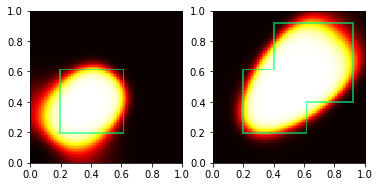

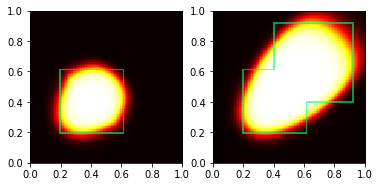

In [ ]:
experiment = Experiment('rectangles-rev', model2, shapes, constraints2)
experiment.run(500)
experiment.save(dir='./models/')